In [1]:
%%capture
!pip install lightautoml

In [4]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14820 sha256=23028ea922c56c45bf7a59639f097e8493faef326d161b6c79dbaec3efdde29b
  Stored in directory: /root/.cache/pip/wheels/94/8d/0b/bdcd83555c3555f91a33f6c2384428d9f163c7d75ab0d272b4
Successfully built gdown


In [11]:
!gdown --id 1luhGPR0zWXCmVAsa5tA74e5z9FE63y3F

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1luhGPR0zWXCmVAsa5tA74e5z9FE63y3F
To: /kaggle/working/big_df.csv
100%|███████████████████████████████████████| 1.48G/1.48G [00:09<00:00, 149MB/s]


In [12]:
!gdown --id 1IwFMbWJNUU1G-UkbjpOAq8jAYpCZrLfM

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1IwFMbWJNUU1G-UkbjpOAq8jAYpCZrLfM
To: /kaggle/working/train_clusters.csv
100%|███████████████████████████████████████| 62.0M/62.0M [00:00<00:00, 109MB/s]


In [40]:
!gdown --id 1mM1Jt3HcwfEx6lVsqbwHiVFQJuW28WV6

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1mM1Jt3HcwfEx6lVsqbwHiVFQJuW28WV6
To: /kaggle/working/PIndx20.csv
100%|██████████████████████████████████████| 7.70M/7.70M [00:00<00:00, 57.9MB/s]


In [41]:
!gdown --id 1qko7C-EEk1Smf9dB46iSc7DU5kEKIp87

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qko7C-EEk1Smf9dB46iSc7DU5kEKIp87
To: /kaggle/working/test_dataset_test.csv
100%|█████████████████████████████████████████| 656M/656M [00:04<00:00, 160MB/s]


In [42]:
!gdown --id 14mCgEKtF_Z-p6qLkvs-ovM1WtilHy_N-

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14mCgEKtF_Z-p6qLkvs-ovM1WtilHy_N-
To: /kaggle/working/test_clusters.csv
100%|██████████████████████████████████████| 40.9M/40.9M [00:00<00:00, 93.5MB/s]


In [13]:

# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task


In [14]:

pd.set_option('display.max_columns', None)

In [15]:
big_df = pd.read_csv('./big_df.csv')

In [16]:
N_THREADS = 32
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900*4 # equal to 15*4 minutes
TARGET_NAME = 'label'

In [17]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [18]:
big_df['net_weight'] = (big_df['weight'] - big_df['weight_mfi'])
big_df['total_price'] = (big_df['price_mfi'] + big_df['transport_pay'])

big_df['w/p'] = np.log(big_df['weight_mfi'] + 1) - np.log(big_df['price_mfi']+1)

big_df['post_days'] = pd.to_datetime('2020-11-1') - pd.to_datetime(big_df['ACTDATE'])
big_df['post_days'] = big_df['post_days'].apply(lambda x: x.days)


big_df['delta_log1'] = np.log(big_df['total_qty_oper_login_1']+1) - np.log(big_df['dist_qty_oper_login_1']+1)

big_df['delta_qty_log'] = (big_df['total_qty_oper_login_1'] - big_df['total_qty_oper_login_0'])

big_df['delta_bigi'] = (big_df['total_qty_over_index'] - big_df['total_qty_over_index_and_type'])

def num_tov(x):
    if x == '0' or x=='':
        return 0
    else:
        return x.count(',')+1
    

big_df['num_prod'] = big_df['name_mfi'].apply(num_tov)

In [19]:
tr_clust = pd.read_csv('./train_clusters.csv')

In [20]:
big_df['cluster'] = tr_clust['cluster']

In [21]:
tr_data, te_data = train_test_split(
    big_df.drop(['Unnamed: 0','name_mfi','oper_type + oper_attr','ACTDATE','is_privatecategory','is_in_yandex','mailtype','is_wrong_sndr_name','is_wrong_address','is_return','priority','directctg','class','is_wrong_rcpn_name','index_oper','new_index_oper','OPSSUBM'],axis = 1), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (4800000, 29), te_data = (1200000, 29)


,id,type,weight,mailctg,mailrank,transport_pay,postmark,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_phone_number,label,op_t,op_a,CITY,AREA,net_weight,total_price,w/p,post_days,delta_log1,delta_qty_log,delta_bigi,num_prod,cluster
3604976,4619089,П,141.0,1.0,0.0,22.59,0.0,37.0,190.0,7.0,72206.0,7646.0,79852.0,1110354.0,1,0,1041,-1,КЛИНЦЫ,БРЯНСКАЯ ОБЛАСТЬ,104.0,212.59,-1.614687,4777.0,9.107851,64560.0,1030502.0,1,15
5936295,1004170,Участок,736.0,1.0,0.0,50.12,0.0,520.0,300.0,15.0,487093.0,147547.0,634640.0,4821535.0,0,0,1020,-1,ЕЛИЗОВО,КАМЧАТСКИЙ КРАЙ,216.0,350.12,0.548640,977.0,10.323624,339546.0,4186895.0,1,0
1804115,2569448,ММПО,175.0,0.0,0.0,0.00,0.0,80.0,100.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,1,1,1004,-1,ШАРАПОВО,МОСКВА,95.0,100.00,-0.220671,213.0,11.165837,-22357201.0,5038002.0,1,23
4351206,5506132,Участок,753.0,1.0,0.0,50.81,0.0,1.0,7.0,27.0,9164121.0,4770841.0,13934962.0,14030822.0,1,0,1023,-1,ЕКАТЕРИНБУРГ,СВЕРДЛОВСКАЯ ОБЛАСТЬ,752.0,57.81,-1.386294,2568.0,12.698602,4393280.0,95860.0,1,0
5014389,727375,Цех,1138.0,1.0,0.0,68.54,0.0,10.0,380.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,1018,-1,ШАРАПОВО,МОСКВА,1128.0,448.54,-3.544904,213.0,12.688917,60602704.0,14968387.0,1,13


In [22]:
del big_df


In [23]:
del tr_clust

In [24]:
task = Task('binary', loss = 'logloss', metric = 'auc')

In [25]:
roles = {
    'target': TARGET_NAME,
    'drop': ['id']
}

In [26]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [27]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[18:48:31] Stdout logging level is INFO.
[18:48:31] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[18:48:31] Task: binary

[18:48:31] Start automl preset with listed constraints:
[18:48:31] - time: 3600.00 seconds
[18:48:31] - CPU: 32 cores
[18:48:31] - memory: 16 GB

[18:48:31] Train data shape: (4800000, 29)

[18:48:48] Layer 1 train process start. Time left 3583.75 secs
[18:53:07] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:57:23] Time limit exceeded after calculating fold 2

[18:57:25] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.983952478746657
[18:57:25] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:57:25] Time left 3066.59 secs

[19:05:37] Selector_LightGBM fitting and predicting completed
[19:10:53] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:24:12] Time limit exceeded after calculating fold 0

[19:24:13] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9914862003951052
[19:24:

Default metric period is 5 because AUC is/are not implemented for GPU


[19:29:11] Time limit exceeded after calculating fold 0

[19:29:11] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9910613443823967
[19:29:11] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[19:29:11] Time left 1159.92 secs

[19:29:11] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[19:29:11] Layer 1 training completed.

[19:29:13] Blending: optimization starts with equal weights and score 0.9869509406991253
[19:29:27] Blending: iteration 0: score = 0.9915497182918277, weights = [0.         0.71951324 0.28048673]
[19:29:42] Blending: iteration 1: score = 0.9915497182918277, weights = [0.         0.7195133  0.28048673]
[19:29:57] Blending: iteration 2: score = 0.9915497182918277, weights = [0.         0.7195133  0.28048673]
[19:29:57] Blending: no score update. Terminated

[19:29:57] Automl preset training completed in 2485.96 seconds

[19:29:57] Model description:
Final prediction for new objects (level 0) = 
	 0.71951 * (1 averaged m

CPU times: user 108 ms, sys: 25.6 ms, total: 134 ms
Wall time: 206 ms


<AxesSubplot:xlabel='Feature'>

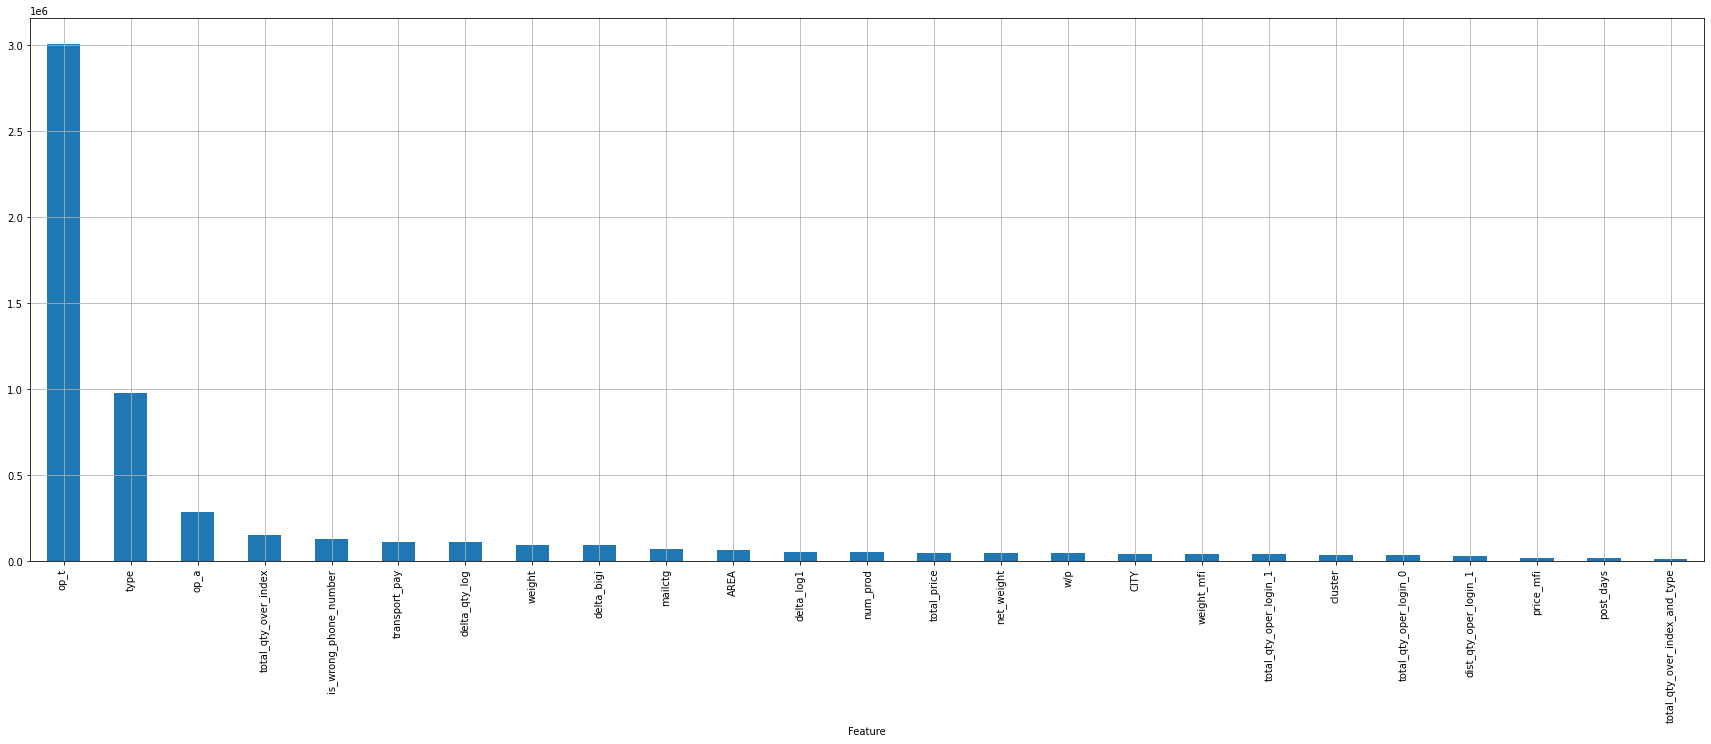

In [28]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [29]:
te_pred = automl.predict(te_data)

In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
roc_auc_score(te_data['label'].values,te_pred.data[:,0])

0.991759428838285

In [32]:
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score

In [35]:


metric = pd.DataFrame(columns = ['alpha','precision','recall','f1','accuracy','roc_auc','macro_recall','ovo_auc'])

for x in np.array(list(range(20)))/100 :
    row = []
    tr = te_data['label'].values
    pr = 1*(te_pred.data[:,0] >= x)
    row.append(x)

    row.append(precision_score(te_data['label'].values ,pr))
    row.append(recall_score(te_data['label'].values ,pr))
    row.append(f1_score(te_data['label'].values ,pr))
    row.append(accuracy_score(te_data['label'].values ,pr))
    

    fp = np.sum((pr == 1) & (tr == 0))
    tp = np.sum((pr == 1) & (tr == 1))

    fn = np.sum((pr == 0) & (tr == 1))
    tn = np.sum((pr == 0) & (tr == 0))

    fpr = (fp / (fp + tn))
    tpr = (tp / (tp + fn))

    roc = (1+ tpr - fpr)/2 


    row.append(roc)
    row.append(recall_score(te_data['label'].values ,pr, average = "macro" ))
    row.append(roc_auc_score(te_data['label'].values ,pr, multi_class='ovo'))

    metric.loc[len(metric.index)] = row



In [36]:
metric

,alpha,precision,recall,f1,accuracy,roc_auc,macro_recall,ovo_auc
0,0.00,0.028608,1.000000,0.055625,0.028608,0.500000,0.500000,0.500000
1,0.01,0.394979,0.998194,0.565997,0.956206,0.976582,0.976582,0.976582
2,0.02,0.402956,0.997437,0.574015,0.957647,0.976956,0.976956,0.976956
3,0.03,0.407093,0.996767,0.578087,0.958376,0.977006,0.977006,0.977006
4,0.04,0.412239,0.995689,0.583072,0.959263,0.976940,0.976940,0.976940
5,0.05,0.417511,0.994524,0.588123,0.960149,0.976830,0.976830,0.976830
6,0.06,0.422771,0.993038,0.593057,0.961013,0.976554,0.976554,0.976554
7,0.07,0.427267,0.991203,0.597134,0.961738,0.976036,0.976036,0.976036
8,0.08,0.431752,0.989018,0.601098,0.962447,0.975341,0.975341,0.975341
9,0.09,0.436387,0.986135,0.605033,0.963167,0.974312,0.974312,0.974312


In [38]:
import joblib

joblib.dump(automl, 'model_811.pkl')

['model_811.pkl']

In [39]:
def op_t(x):
    return x[:x.find('_')]
def op_a(x):
    return x[x.find('_')+1:]

In [46]:
qq =  pd.read_csv('./PIndx20.csv')
qq['index_oper'] = qq['INDEX'].values



def p_to_int(x):
    if type(x) == float:
        return int(x)
    return x[:x.find('.')]

#df['index_oper'] = df['index_oper'].apply(p_to_int)
def nd(x):
    if x == '':
        return 0
    x = int(x)
    if x // 10**5 >0:
        return 6
    elif x // 10**4 >0:
        return 5
    elif x // 10**3 >0:
        return 4

def from5t6(x):
    if x == '':
        return 0
    x = int(x)
    if x // 10**5 == 0:
        return x*10
    return x

In [43]:
test_df = pd.read_csv('./test_dataset_test.csv')
test_df["is_in_yandex"] = pd.Categorical(test_df["is_in_yandex"])
test_df["is_in_yandex"].astype('category').cat.codes
test_df["is_in_yandex"] = test_df["is_in_yandex"].cat.codes

test_df["is_return"] = pd.Categorical(test_df["is_return"])
test_df["is_return"].astype('category').cat.codes
test_df["is_return"] = test_df["is_return"].cat.codes

test_df['op_t'] = test_df['oper_type + oper_attr'].apply(op_t).astype('int64')
test_df['op_a'] = test_df['oper_type + oper_attr'].apply(op_a).astype('int64')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [47]:
test_df['index_oper'] = test_df['index_oper'].apply(p_to_int)


pld2 = pd.DataFrame(columns = ['index_oper','new_index_oper','OPSSUBM','REGION','AUTONOM','CITY','ACTDATE'])
pld = pd.DataFrame(columns = ['index_oper','new_index_oper'])
pld['index_oper'] = test_df['index_oper'].values
pld2['index_oper'] = test_df['index_oper'].values
qq['new_index_oper'] = qq['INDEX'].values

for i in range(10):
    def from5t6(x):
        if x == '':
            return 0
        x = int(float(x))
        if x // 10**5 == 0:
            return x*10 + i
        return x
    pld['new_index_oper'] = pld['index_oper'].apply(from5t6)
    pld2['new_index_oper'] = pld2['index_oper'].apply(from5t6)
    
    pz = pd.merge(pld, qq[['new_index_oper','OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']],how = 'left', on="new_index_oper")
    
    pld['index_oper'][pz['ACTDATE'].isna() == False]['index_oper'] = pz[pz['ACTDATE'].isna() == False]['new_index_oper'].values
    pld2['index_oper'][pz['ACTDATE'].isna() == False]['index_oper'] = pz[pz['ACTDATE'].isna() == False]['new_index_oper'].values
    #pld[['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']] = pz[pz['ACTDATE'].isna() == False][['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']].values
    pld2.loc[pz['ACTDATE'].isna() == False,['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']] = pz[pz['ACTDATE'].isna() == False][['OPSSUBM','REGION','AUTONOM','CITY','ACTDATE']].values


pld2['AREA'] = (pld2['REGION'].fillna('') + pld2['AUTONOM'].fillna('')).values
pld2.drop(['REGION','AUTONOM'],axis = 1,inplace = True)
pld2.loc[pld2['AREA'] == 'МОСКВА','CITY'] = pld2[pld2['AREA'] == 'МОСКВА']['CITY'].fillna('МОСКВА').values

big_test_df = pd.concat([test_df,pld2.drop(['index_oper'],axis=1)],axis = 1)
big_test_df['ACTDATE'] = pd.to_datetime(big_test_df['ACTDATE'])


def npust(x):
    if x == '':
        return 0
    return int(x)

    
big_test_df['index_oper'] = big_test_df['index_oper'].apply(npust)
big_test_df['new_index_oper'] = big_test_df['new_index_oper'].apply(npust)
big_test_df['OPSSUBM'] = big_test_df['OPSSUBM'].fillna(0).apply(npust)

big_test_df['net_weight'] = (big_test_df['weight'] - big_test_df['weight_mfi'])
big_test_df['total_price'] = (big_test_df['price_mfi'] + big_test_df['transport_pay'])

big_test_df['w/p'] = np.log(big_test_df['weight_mfi'] + 1) - np.log(big_test_df['price_mfi']+1)

big_test_df['post_days'] = pd.to_datetime('2020-11-1') - pd.to_datetime(big_test_df['ACTDATE'])
big_test_df['post_days'] = big_test_df['post_days'].apply(lambda x: x.days)


big_test_df['delta_log1'] = np.log(big_test_df['total_qty_oper_login_1']+1) - np.log(big_test_df['dist_qty_oper_login_1']+1)

big_test_df['delta_qty_log'] = (big_test_df['total_qty_oper_login_1'] - big_test_df['total_qty_oper_login_0'])

big_test_df['delta_bigi'] = (big_test_df['total_qty_over_index'] - big_test_df['total_qty_over_index_and_type'])

def num_tov(x):
    if x == '0' or x=='':
        return 0
    else:
        return x.count(',')+1
    

big_test_df['num_prod'] = big_test_df['name_mfi'].apply(num_tov)

In [49]:
del tr_data

In [50]:
test_cluster = pd.read_csv('./test_clusters.csv')

In [51]:
big_test_df['cluster'] = test_cluster['cluster'].values

In [52]:
del test_cluster

In [54]:
big_test_df['op_t'] = big_test_df['oper_type + oper_attr'].apply(op_t).astype('int64')
big_test_df['op_a'] = big_test_df['oper_type + oper_attr'].apply(op_a).astype('int64')

In [56]:
big_test_df.drop(['name_mfi','oper_type + oper_attr','ACTDATE','is_privatecategory','is_in_yandex','mailtype','is_wrong_sndr_name','is_wrong_address','is_return','priority','directctg','class','is_wrong_rcpn_name','index_oper','new_index_oper','OPSSUBM'],axis = 1,inplace = True)

In [58]:
end_test_pred = automl.predict(big_test_df)

In [59]:
end_test_pred

array([[1.6112476e-06],
       [1.8635577e-06],
       [1.9524536e-05],
       ...,
       [3.8599914e-08],
       [3.3109592e-07],
       [3.7032518e-07]], dtype=float32)

In [68]:
sum(1*(end_test_pred.data[:,0] >= 0.1))

255069

In [69]:
submission = pd.DataFrame(columns = ['id','label'])
submission['id'] = test_df['id'].values
submission['label'] = 1*(end_test_pred.data[:,0] >= 0.1)


In [70]:
submission['label'].value_counts()

0    3744931
1     255069
Name: label, dtype: int64

In [71]:
submission.to_csv('submission_8_11_100.csv',index = False)